In [1]:
from utils import *
%matplotlib inline

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [3]:
train_data, train_results, test_data, test_results = read_data()

In [4]:
from sklearn.ensemble import GradientBoostingRegressor

def gradient_boosting_regressor(train_data, train_results, test_data, prediction_mode='delta', **est_parameters):
      
    if prediction_mode == 'delta':
        make_results = make_delta
        unmake_results = unmake_delta
    else:
        make_results = lambda train_data, train_results: train_results
        unmake_results = lambda test_data, prediction: prediction
    
    train_data_ = to_model_with_features(train_data)
    train_results_ = to_model(make_results(train_data, train_results))
    
    test_data_ = to_model_with_features(test_data)
    test_results_ = np.zeros_like(test_data)
    
    for i in range(train_results_.shape[1]):
        est = GradientBoostingRegressor(random_state=0, **est_parameters)    
        est.fit(train_data_, train_results_[:,i]) 
        test_results_[i//2,i%2::2] = est.predict(test_data_)
        
    return unmake_results(test_data, test_results_)

1/4: 2016-12-12 16:09:28
2/4: 2016-12-12 16:21:41
3/4: 2016-12-12 16:33:36
4/4: 2016-12-12 16:45:35
done! 2016-12-12 16:57:22
Results: [-3.5287508597185075, -3.5333017279048828, -3.5348514018244197, -3.5376396307064502]


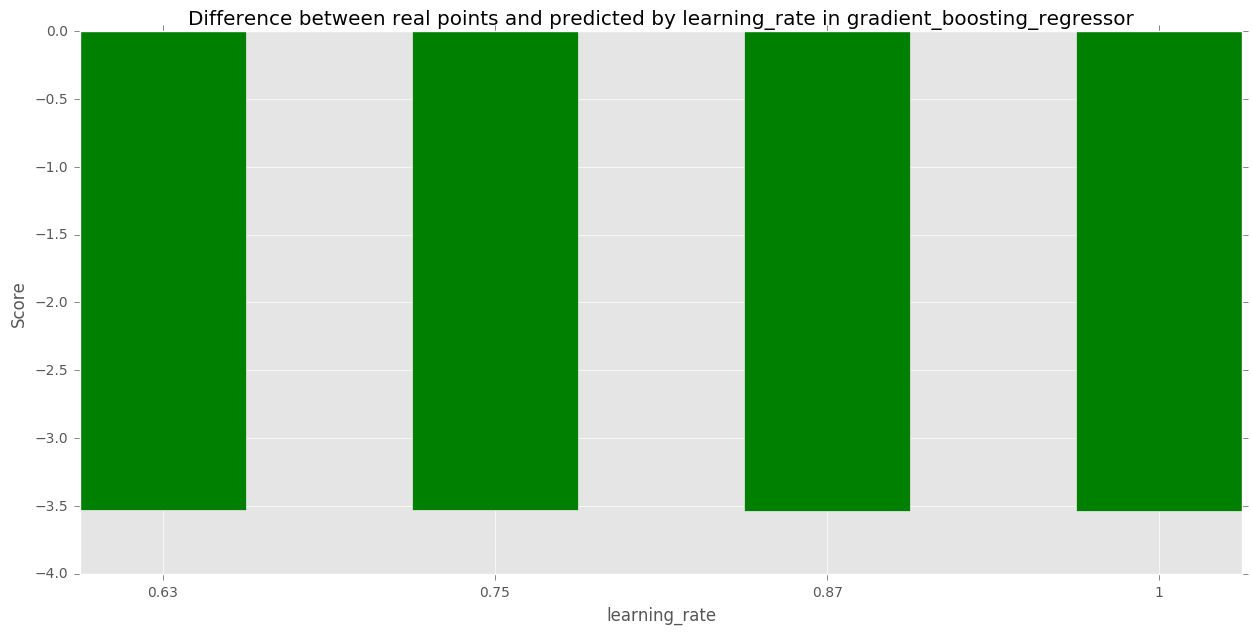

In [6]:
compare_results(function=gradient_boosting_regressor, test_results=test_results, parameter_name="learning_rate",
                list_of_values=[0.63, 0.75, 0.87, 1], train_data=train_data, train_results=train_results,
                test_data=test_data, prediction_mode='delta')

1/4: 2016-12-12 16:58:45
2/4: 2016-12-12 17:01:14
3/4: 2016-12-12 17:07:13
4/4: 2016-12-12 17:19:01
done! 2016-12-12 17:44:21
Results: [-3.562773124091799, -3.5482665800138582, -3.5350884325522971, -3.5234129739651969]


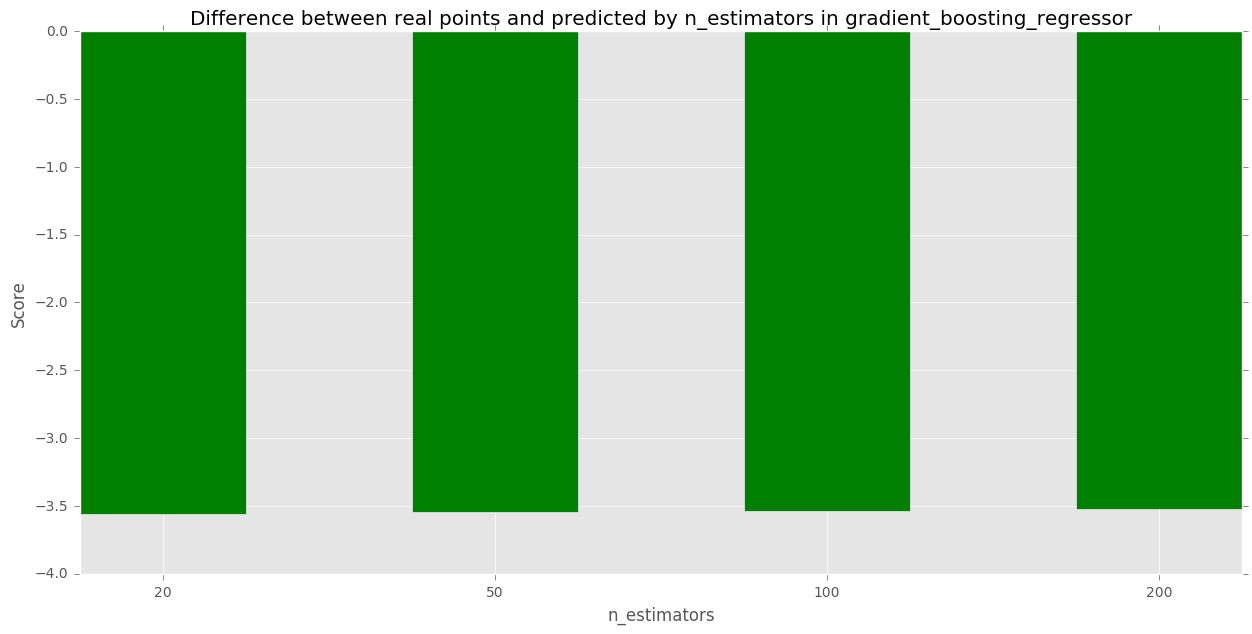

In [7]:
compare_results(function=gradient_boosting_regressor, test_results=test_results, parameter_name="n_estimators",
                list_of_values=[20, 50, 100, 200], train_data=train_data, train_results=train_results,
                test_data=test_data, prediction_mode='delta', learning_rate=0.5)

1/4: 2016-12-12 17:46:57
2/4: 2016-12-12 17:47:48
3/4: 2016-12-12 17:50:22
4/4: 2016-12-12 17:56:02
done! 2016-12-12 18:59:50
Results: [-3.6818041538026929, -3.562773124091799, -3.530420082831232, -3.5189734669067469]


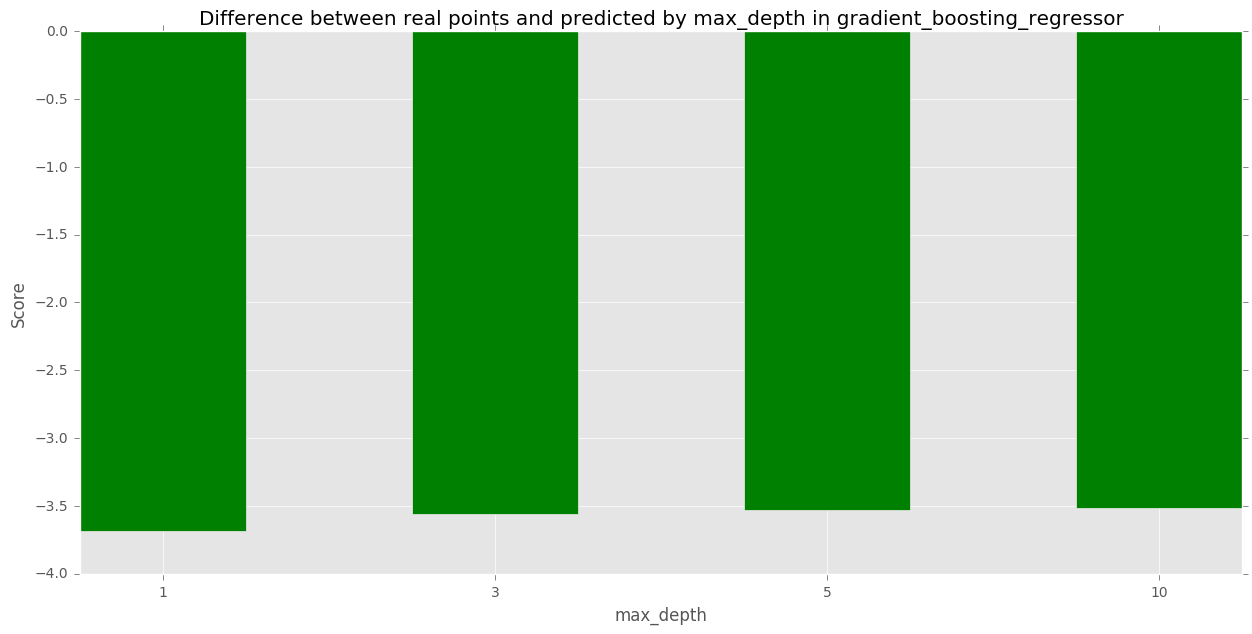

In [8]:
compare_results(function=gradient_boosting_regressor, test_results=test_results, parameter_name="max_depth",
                list_of_values=[1, 3, 5, 10], train_data=train_data, train_results=train_results,
                test_data=test_data, prediction_mode='delta', learning_rate=0.5, n_estimators=20)

In [6]:
est = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=50, max_features=0.4)
    
make_results = make_delta
unmake_results = unmake_delta

est.fit(to_model_with_features(train_data), to_model(make_results(train_data, train_results))) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.4, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [7]:
importances = est.feature_importances_

In [8]:
indices = np.argsort(importances)[::-1]

In [9]:
num_features = to_model_with_features(train_data).shape[1]

In [10]:
print("Feature ranking:")

for f in range(num_features):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 13 (0.238339)
2. feature 30 (0.162772)
3. feature 17 (0.108926)
4. feature 12 (0.094460)
5. feature 16 (0.062014)
6. feature 29 (0.054296)
7. feature 26 (0.033142)
8. feature 11 (0.029584)
9. feature 15 (0.024379)
10. feature 14 (0.023785)
11. feature 27 (0.023714)
12. feature 28 (0.021804)
13. feature 25 (0.015878)
14. feature 21 (0.014105)
15. feature 10 (0.009777)
16. feature 9 (0.007015)
17. feature 4 (0.006660)
18. feature 20 (0.006543)
19. feature 5 (0.006167)
20. feature 3 (0.005976)
21. feature 0 (0.005859)
22. feature 8 (0.005791)
23. feature 2 (0.005646)
24. feature 6 (0.005634)
25. feature 1 (0.005444)
26. feature 7 (0.005250)
27. feature 19 (0.004065)
28. feature 18 (0.003591)
29. feature 22 (0.003147)
30. feature 24 (0.003129)
31. feature 23 (0.003108)


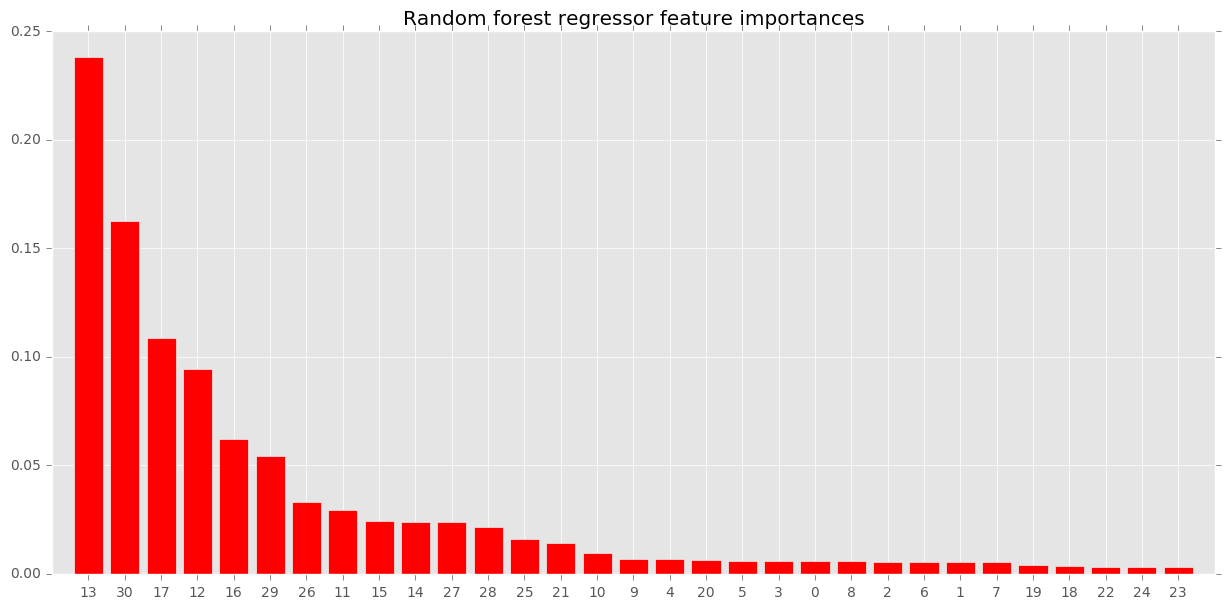

In [11]:
plt.figure()
plt.title("Random forest regressor feature importances")
plt.bar(range(num_features), importances[indices],
       color="r", align="center")
plt.xticks(range(num_features), indices)
plt.xlim([-1, num_features])
plt.show()